<a href="https://colab.research.google.com/github/nathon-tadeo/4106-Realtime-ML/blob/main/homework_2_real_time_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code was ran on VScode with Anaconda env
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)
print(f"Using device: {device}")
print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")
'''

Using device: cuda
Current device number is: 0
GPU name is: NVIDIA GeForce RTX 4070 SUPER


Epoch [1/20], Train Loss: 1.6175, Val Loss: 1.3036, Val Accuracy: 0.5200
Epoch [2/20], Train Loss: 1.1572, Val Loss: 1.0076, Val Accuracy: 0.6481
Epoch [3/20], Train Loss: 0.9226, Val Loss: 0.9108, Val Accuracy: 0.6855
Epoch [4/20], Train Loss: 0.7687, Val Loss: 0.8205, Val Accuracy: 0.7239
Epoch [5/20], Train Loss: 0.6405, Val Loss: 0.8493, Val Accuracy: 0.7166
Epoch [6/20], Train Loss: 0.5278, Val Loss: 0.8325, Val Accuracy: 0.7330
Epoch [7/20], Train Loss: 0.4219, Val Loss: 0.8854, Val Accuracy: 0.7325
Epoch [8/20], Train Loss: 0.3429, Val Loss: 0.9932, Val Accuracy: 0.7206
Epoch [9/20], Train Loss: 0.2671, Val Loss: 1.0322, Val Accuracy: 0.7345
Epoch [10/20], Train Loss: 0.2212, Val Loss: 1.1270, Val Accuracy: 0.7370
Epoch [11/20], Train Loss: 0.1823, Val Loss: 1.2983, Val Accuracy: 0.7341
Epoch [12/20], Train Loss: 0.1613, Val Loss: 1.3848, Val Accuracy: 0.7227
Epoch [13/20], Train Loss: 0.1538, Val Loss: 1.4185, Val Accuracy: 0.7268
Epoch [14/20], Train Loss: 0.1360, Val Loss: 1.

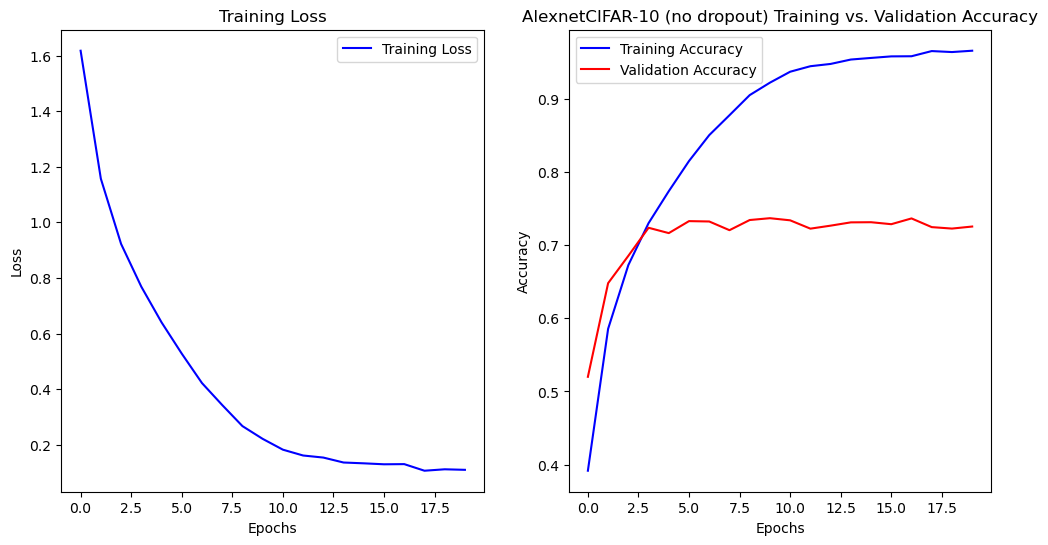


Final Test Accuracy: 0.7256
Precision: 0.7280
Recall: 0.7256
F1 Score: 0.7256


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-10 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  # Resize to match CIFAR-10 (already 32x32)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the AlexNet model
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),

            nn.Linear(4096, 4096),
            nn.ReLU(),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function with validation loss tracking
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time


# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-10 (no dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.5644, Val Loss: 1.2202, Val Accuracy: 0.5521
Epoch [2/20], Train Loss: 1.1108, Val Loss: 1.0075, Val Accuracy: 0.6447
Epoch [3/20], Train Loss: 0.9251, Val Loss: 0.8976, Val Accuracy: 0.6841
Epoch [4/20], Train Loss: 0.7994, Val Loss: 0.8723, Val Accuracy: 0.7039
Epoch [5/20], Train Loss: 0.7006, Val Loss: 0.7955, Val Accuracy: 0.7284
Epoch [6/20], Train Loss: 0.6358, Val Loss: 0.7776, Val Accuracy: 0.7416
Epoch [7/20], Train Loss: 0.5778, Val Loss: 0.8053, Val Accuracy: 0.7328
Epoch [8/20], Train Loss: 0.5297, Val Loss: 0.7989, Val Accuracy: 0.7418
Epoch [9/20], Train Loss: 0.4833, Val Loss: 0.7963, Val Accuracy: 0.7476
Epoch [10/20], Train Loss: 0.4437, Val Loss: 0.8371, Val Accuracy: 0.7472
Epoch [11/20], Train Loss: 0.4096, Val Loss: 0.8488, Val Accuracy: 0.7464
Epoch [12/20], Train Loss: 0.3793, Val Loss: 0.8500, Val Accuracy: 0.7462
Epoch [13/20], Train Loss: 0.3768, Val Loss: 0.8161, Val Accuracy: 0.7487
Epoch [14/20], Train Loss: 0.3447, Val Loss: 0.

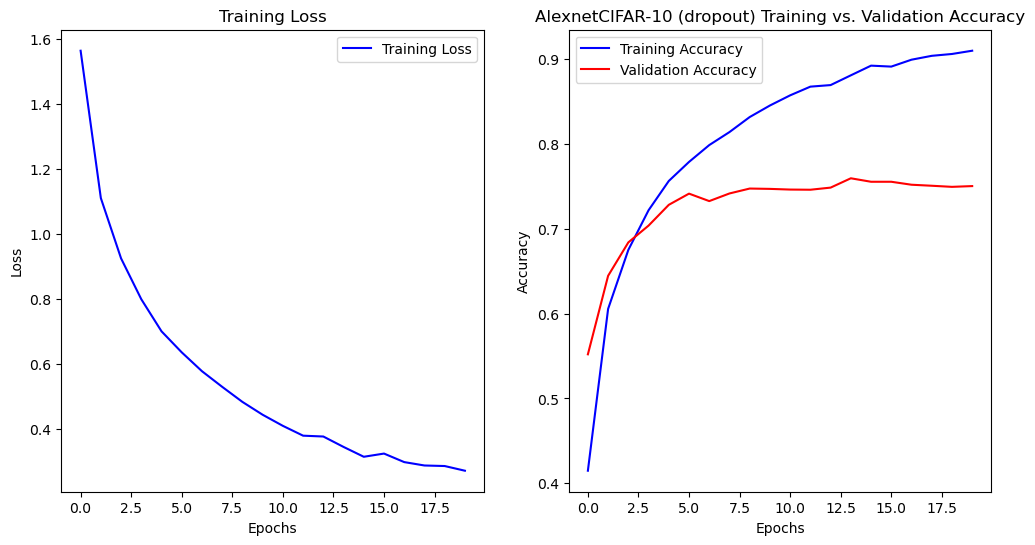


Final Test Accuracy: 0.7505
Precision: 0.7532
Recall: 0.7505
F1 Score: 0.7510


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-10 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the AlexNet model
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-10 (dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.0311, Val Loss: 3.5857, Val Accuracy: 0.1389
Epoch [2/20], Train Loss: 3.3490, Val Loss: 3.1291, Val Accuracy: 0.2261
Epoch [3/20], Train Loss: 2.9119, Val Loss: 2.8320, Val Accuracy: 0.2838
Epoch [4/20], Train Loss: 2.5714, Val Loss: 2.7319, Val Accuracy: 0.3187
Epoch [5/20], Train Loss: 2.2690, Val Loss: 2.5605, Val Accuracy: 0.3568
Epoch [6/20], Train Loss: 1.9577, Val Loss: 2.5465, Val Accuracy: 0.3668
Epoch [7/20], Train Loss: 1.6471, Val Loss: 2.6762, Val Accuracy: 0.3705
Epoch [8/20], Train Loss: 1.3138, Val Loss: 2.8483, Val Accuracy: 0.3723
Epoch [9/20], Train Loss: 1.0044, Val Loss: 3.3324, Val Accuracy: 0.3616
Epoch [10/20], Train Loss: 0.7265, Val Loss: 3.6967, Val Accuracy: 0.3735
Epoch [11/20], Train Loss: 0.5594, Val Loss: 4.2781, Val Accuracy: 0.3546
Epoch [12/20], Train Loss: 0.4462, Val Loss: 4.6897, Val Accuracy: 0.3542
Epoch [13/20], Train Loss: 0.3985, Val Loss: 4.9790, Val Accuracy: 0.3541
Epoch [14/20], Train Loss: 0.3403, Val Loss: 5.

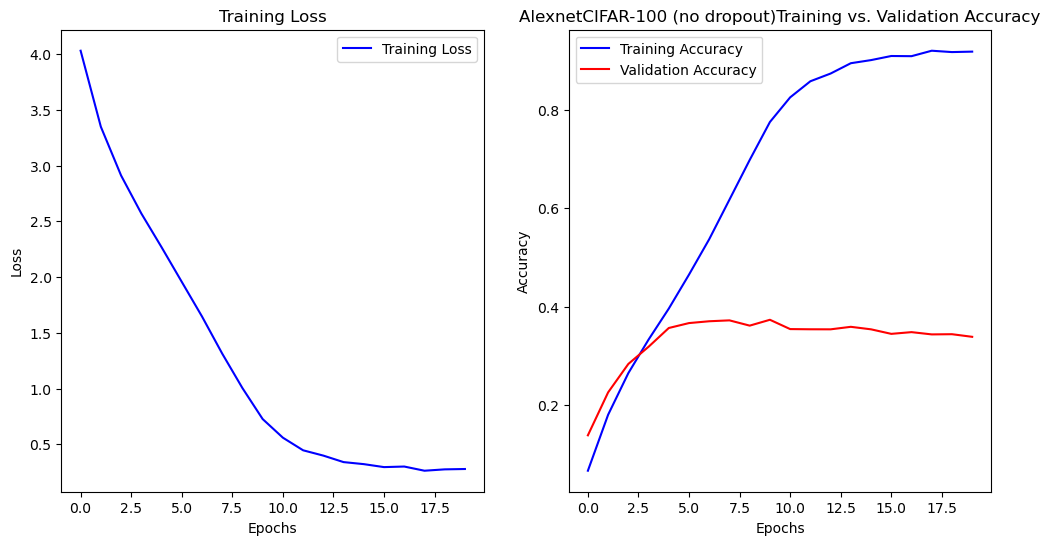


Final Test Accuracy: 0.3389
Precision: 0.3534
Recall: 0.3389
F1 Score: 0.3408


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-100 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)



print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-100 (no dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.1352, Val Loss: 3.7152, Val Accuracy: 0.1154
Epoch [2/20], Train Loss: 3.5357, Val Loss: 3.2457, Val Accuracy: 0.2110
Epoch [3/20], Train Loss: 3.1909, Val Loss: 3.0128, Val Accuracy: 0.2573
Epoch [4/20], Train Loss: 2.9504, Val Loss: 2.9047, Val Accuracy: 0.2785
Epoch [5/20], Train Loss: 2.7744, Val Loss: 2.7593, Val Accuracy: 0.3063
Epoch [6/20], Train Loss: 2.6212, Val Loss: 2.6801, Val Accuracy: 0.3261
Epoch [7/20], Train Loss: 2.4873, Val Loss: 2.5720, Val Accuracy: 0.3523
Epoch [8/20], Train Loss: 2.3679, Val Loss: 2.5781, Val Accuracy: 0.3478
Epoch [9/20], Train Loss: 2.2521, Val Loss: 2.5086, Val Accuracy: 0.3658
Epoch [10/20], Train Loss: 2.1587, Val Loss: 2.5390, Val Accuracy: 0.3604
Epoch [11/20], Train Loss: 2.0477, Val Loss: 2.5115, Val Accuracy: 0.3718
Epoch [12/20], Train Loss: 1.9551, Val Loss: 2.5179, Val Accuracy: 0.3659
Epoch [13/20], Train Loss: 1.8612, Val Loss: 2.5198, Val Accuracy: 0.3706
Epoch [14/20], Train Loss: 1.7784, Val Loss: 2.

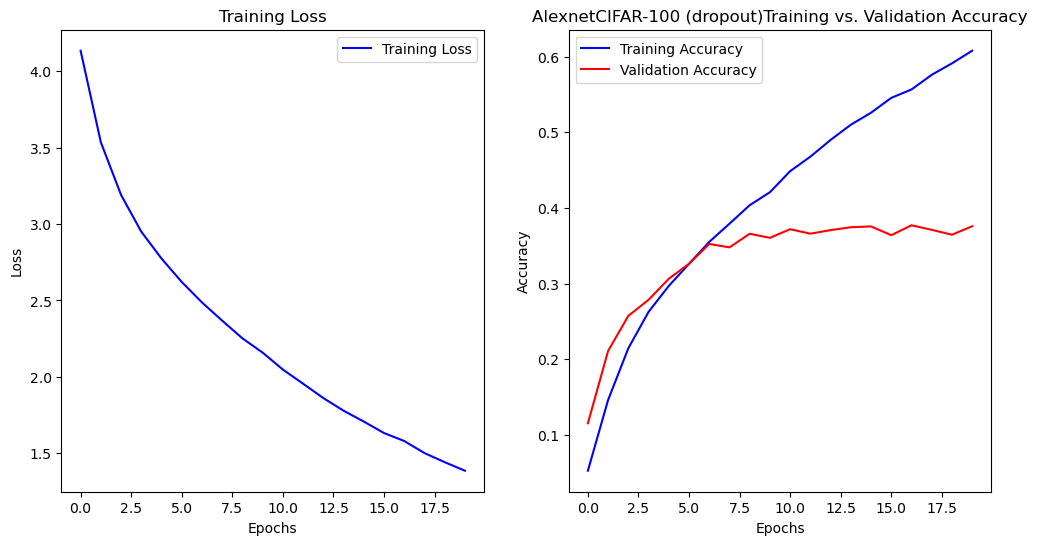


Final Test Accuracy: 0.3757
Precision: 0.3837
Recall: 0.3757
F1 Score: 0.3722


In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-100 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted for CIFAR-10 image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  # Output layer for CIFAR-10
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("AlexnetCIFAR-100 (dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.5960, Val Loss: 1.3005, Val Accuracy: 0.5380
Epoch [2/20], Train Loss: 1.0450, Val Loss: 0.9434, Val Accuracy: 0.6747
Epoch [3/20], Train Loss: 0.7998, Val Loss: 0.8742, Val Accuracy: 0.7085
Epoch [4/20], Train Loss: 0.6489, Val Loss: 0.7888, Val Accuracy: 0.7376
Epoch [5/20], Train Loss: 0.5159, Val Loss: 0.7868, Val Accuracy: 0.7464
Epoch [6/20], Train Loss: 0.4063, Val Loss: 0.8376, Val Accuracy: 0.7433
Epoch [7/20], Train Loss: 0.3065, Val Loss: 0.9393, Val Accuracy: 0.7427
Epoch [8/20], Train Loss: 0.2324, Val Loss: 1.0135, Val Accuracy: 0.7475
Epoch [9/20], Train Loss: 0.1843, Val Loss: 1.1738, Val Accuracy: 0.7438
Epoch [10/20], Train Loss: 0.1503, Val Loss: 1.3370, Val Accuracy: 0.7419
Epoch [11/20], Train Loss: 0.1398, Val Loss: 1.3836, Val Accuracy: 0.7334
Epoch [12/20], Train Loss: 0.1303, Val Loss: 1.3720, Val Accuracy: 0.7361
Epoch [13/20], Train Loss: 0.1124, Val Loss: 1.4589, Val Accuracy: 0.7325
Epoch [14/20], Train Loss: 0.1060, Val Loss: 1.

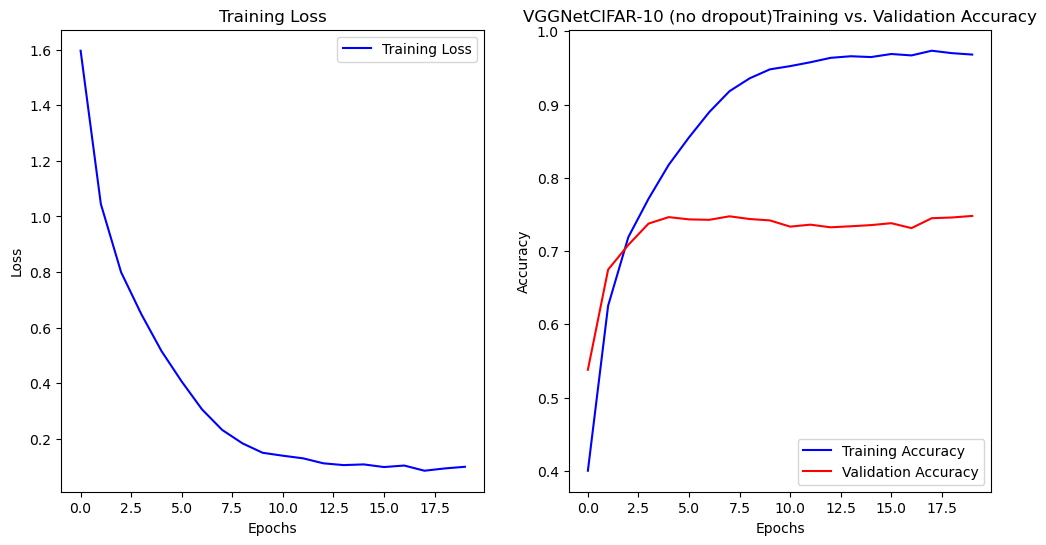


Final Test Accuracy: 0.7480
Precision: 0.7468
Recall: 0.7480
F1 Score: 0.7462


In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-10 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-10 (no dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.6018, Val Loss: 1.2010, Val Accuracy: 0.5609
Epoch [2/20], Train Loss: 1.1039, Val Loss: 0.9579, Val Accuracy: 0.6622
Epoch [3/20], Train Loss: 0.8997, Val Loss: 0.8479, Val Accuracy: 0.7088
Epoch [4/20], Train Loss: 0.7657, Val Loss: 0.8060, Val Accuracy: 0.7224
Epoch [5/20], Train Loss: 0.6690, Val Loss: 0.7619, Val Accuracy: 0.7390
Epoch [6/20], Train Loss: 0.5931, Val Loss: 0.7555, Val Accuracy: 0.7496
Epoch [7/20], Train Loss: 0.5321, Val Loss: 0.7754, Val Accuracy: 0.7401
Epoch [8/20], Train Loss: 0.4741, Val Loss: 0.7670, Val Accuracy: 0.7569
Epoch [9/20], Train Loss: 0.4276, Val Loss: 0.7679, Val Accuracy: 0.7575
Epoch [10/20], Train Loss: 0.4021, Val Loss: 0.7741, Val Accuracy: 0.7627
Epoch [11/20], Train Loss: 0.3738, Val Loss: 0.8533, Val Accuracy: 0.7519
Epoch [12/20], Train Loss: 0.3426, Val Loss: 0.8430, Val Accuracy: 0.7570
Epoch [13/20], Train Loss: 0.3396, Val Loss: 0.8258, Val Accuracy: 0.7651
Epoch [14/20], Train Loss: 0.3102, Val Loss: 0.

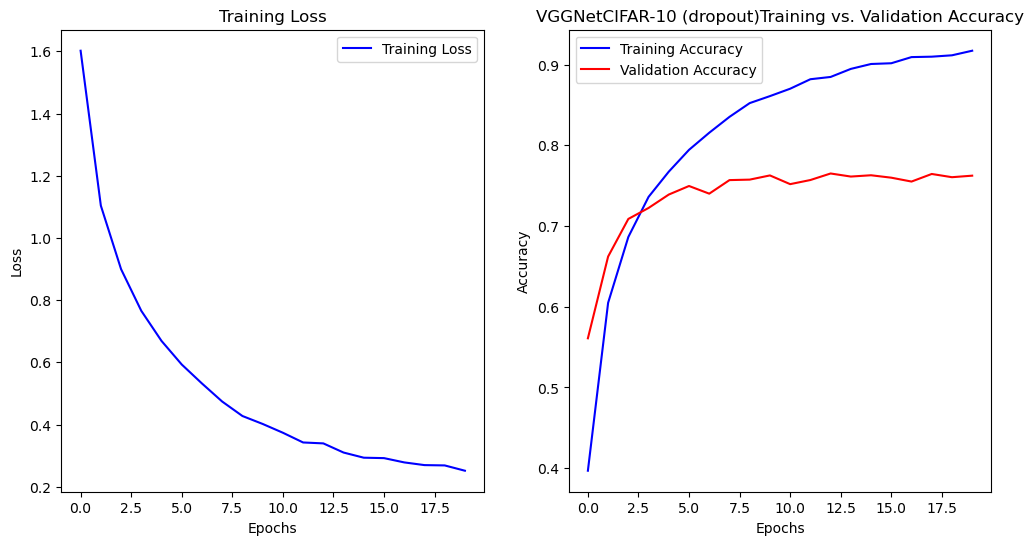


Final Test Accuracy: 0.7624
Precision: 0.7647
Recall: 0.7624
F1 Score: 0.7629


In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-10 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-10 (dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.0767, Val Loss: 3.7347, Val Accuracy: 0.1091
Epoch [2/20], Train Loss: 3.3528, Val Loss: 3.1001, Val Accuracy: 0.2351
Epoch [3/20], Train Loss: 2.8990, Val Loss: 2.8417, Val Accuracy: 0.2878
Epoch [4/20], Train Loss: 2.5498, Val Loss: 2.6335, Val Accuracy: 0.3384
Epoch [5/20], Train Loss: 2.2332, Val Loss: 2.5570, Val Accuracy: 0.3652
Epoch [6/20], Train Loss: 1.9035, Val Loss: 2.5767, Val Accuracy: 0.3774
Epoch [7/20], Train Loss: 1.5748, Val Loss: 2.6898, Val Accuracy: 0.3802
Epoch [8/20], Train Loss: 1.2298, Val Loss: 2.9864, Val Accuracy: 0.3729
Epoch [9/20], Train Loss: 0.9343, Val Loss: 3.3775, Val Accuracy: 0.3645
Epoch [10/20], Train Loss: 0.7009, Val Loss: 3.7661, Val Accuracy: 0.3679
Epoch [11/20], Train Loss: 0.5328, Val Loss: 4.3971, Val Accuracy: 0.3504
Epoch [12/20], Train Loss: 0.4209, Val Loss: 4.8077, Val Accuracy: 0.3559
Epoch [13/20], Train Loss: 0.3814, Val Loss: 5.0315, Val Accuracy: 0.3587
Epoch [14/20], Train Loss: 0.3251, Val Loss: 5.

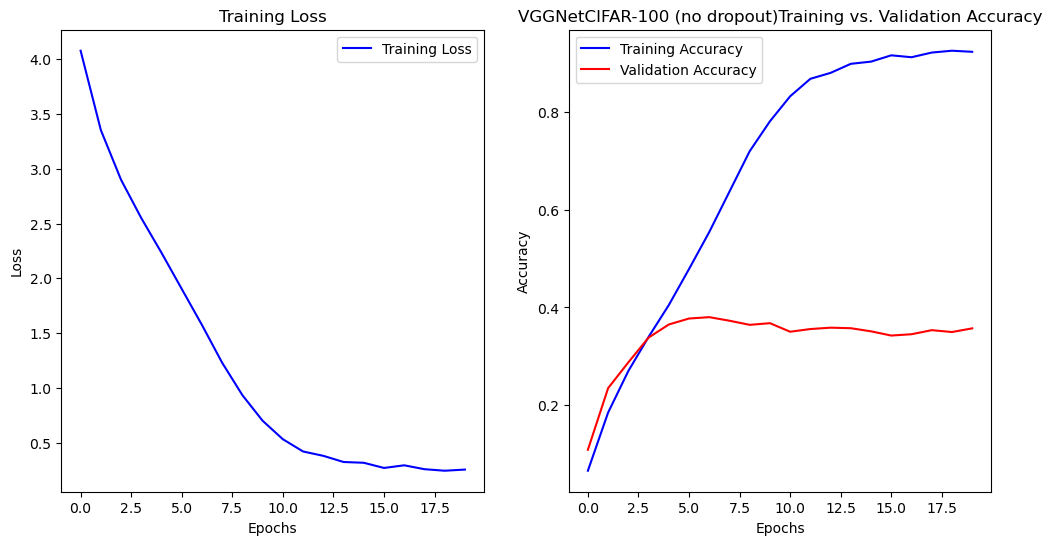


Final Test Accuracy: 0.3573
Precision: 0.3707
Recall: 0.3573
F1 Score: 0.3586


In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-100 without Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-100 (no dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 4.1131, Val Loss: 3.7700, Val Accuracy: 0.1119
Epoch [2/20], Train Loss: 3.4958, Val Loss: 3.2012, Val Accuracy: 0.2178
Epoch [3/20], Train Loss: 3.1194, Val Loss: 2.8844, Val Accuracy: 0.2812
Epoch [4/20], Train Loss: 2.8444, Val Loss: 2.7432, Val Accuracy: 0.3088
Epoch [5/20], Train Loss: 2.6344, Val Loss: 2.6147, Val Accuracy: 0.3386
Epoch [6/20], Train Loss: 2.4603, Val Loss: 2.5212, Val Accuracy: 0.3531
Epoch [7/20], Train Loss: 2.2974, Val Loss: 2.5181, Val Accuracy: 0.3566
Epoch [8/20], Train Loss: 2.1559, Val Loss: 2.4099, Val Accuracy: 0.3857
Epoch [9/20], Train Loss: 2.0221, Val Loss: 2.3999, Val Accuracy: 0.3842
Epoch [10/20], Train Loss: 1.9072, Val Loss: 2.3603, Val Accuracy: 0.3949
Epoch [11/20], Train Loss: 1.8003, Val Loss: 2.3970, Val Accuracy: 0.3943
Epoch [12/20], Train Loss: 1.7007, Val Loss: 2.4107, Val Accuracy: 0.3962
Epoch [13/20], Train Loss: 1.6088, Val Loss: 2.4128, Val Accuracy: 0.3999
Epoch [14/20], Train Loss: 1.5231, Val Loss: 2.

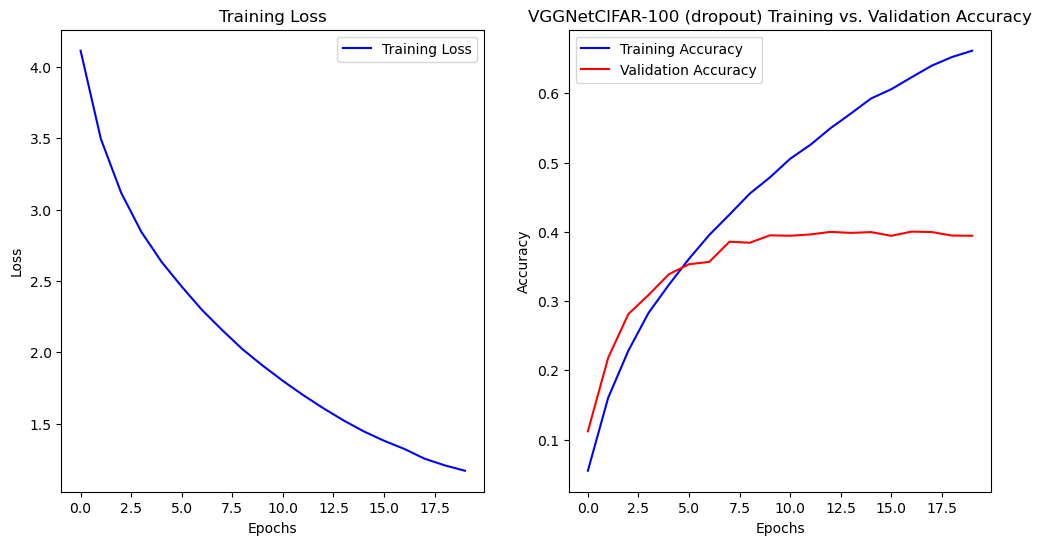


Final Test Accuracy: 0.3943
Precision: 0.4046
Recall: 0.3943
F1 Score: 0.3924


In [ ]:
# Problem 2: Simplified VGGnet model CIFAR-100 with Dropout
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VGGNetCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetCIFAR, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = VGGNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-100 (dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/20], Train Loss: 1.3501, Val Loss: 1.1721, Val Accuracy: 0.5866
Epoch [2/20], Train Loss: 0.9515, Val Loss: 0.8991, Val Accuracy: 0.6812
Epoch [3/20], Train Loss: 0.7882, Val Loss: 0.8478, Val Accuracy: 0.6999
Epoch [4/20], Train Loss: 0.6645, Val Loss: 0.8070, Val Accuracy: 0.7307
Epoch [5/20], Train Loss: 0.5757, Val Loss: 0.7598, Val Accuracy: 0.7511
Epoch [6/20], Train Loss: 0.4814, Val Loss: 0.7294, Val Accuracy: 0.7542
Epoch [7/20], Train Loss: 0.4010, Val Loss: 0.7053, Val Accuracy: 0.7660
Epoch [8/20], Train Loss: 0.3262, Val Loss: 0.7441, Val Accuracy: 0.7744
Epoch [9/20], Train Loss: 0.2638, Val Loss: 0.7991, Val Accuracy: 0.7680
Epoch [10/20], Train Loss: 0.2166, Val Loss: 0.9143, Val Accuracy: 0.7554
Epoch [11/20], Train Loss: 0.1765, Val Loss: 0.9151, Val Accuracy: 0.7650
Epoch [12/20], Train Loss: 0.1358, Val Loss: 0.9559, Val Accuracy: 0.7668
Epoch [13/20], Train Loss: 0.1362, Val Loss: 1.0226, Val Accuracy: 0.7687
Epoch [14/20], Train Loss: 0.1021, Val Loss: 1.

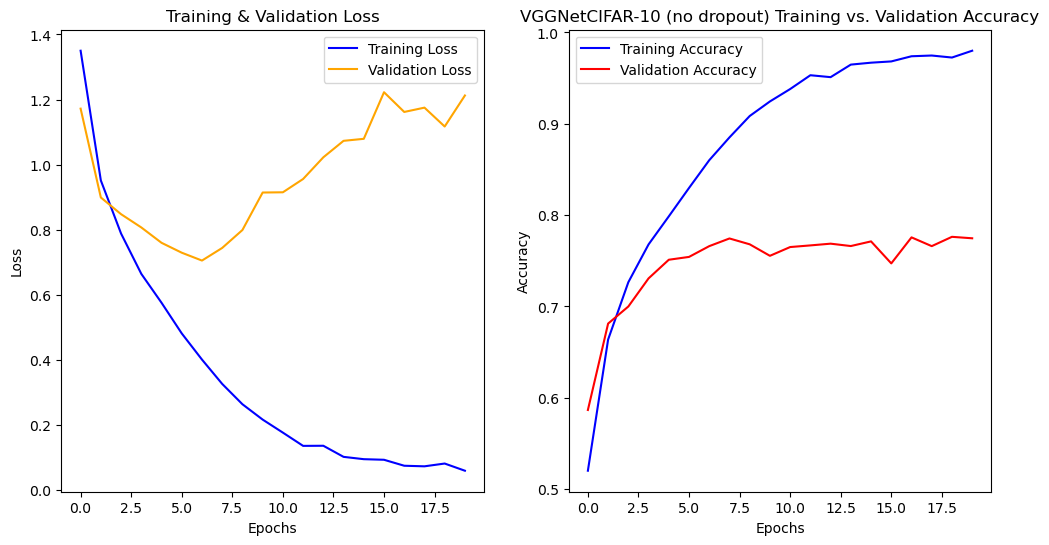


Final Test Accuracy: 0.7746
Precision: 0.7783
Recall: 0.7746
F1 Score: 0.7757


In [ ]:
# Problem 3: Simplified VGGnet model CIFAR-10 without Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Resnet Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

# ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.plot(range(len(val_losses)), val_losses, label="Validation Loss", color="orange")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetCIFAR-10 (no dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Train Loss: 1.8396, Val Loss: 1.4369, Val Accuracy: 0.4751
Epoch [2/20], Train Loss: 1.4593, Val Loss: 1.2611, Val Accuracy: 0.5501
Epoch [3/20], Train Loss: 1.2882, Val Loss: 1.0477, Val Accuracy: 0.6262
Epoch [4/20], Train Loss: 1.1739, Val Loss: 1.0095, Val Accuracy: 0.6458
Epoch [5/20], Train Loss: 1.0917, Val Loss: 0.9069, Val Accuracy: 0.6766
Epoch [6/20], Train Loss: 1.0355, Val Loss: 0.8960, Val Accuracy: 0.6855
Epoch [7/20], Train Loss: 0.9935, Val Loss: 0.8391, Val Accuracy: 0.7090
Epoch [8/20], Train Loss: 0.9454, Val Loss: 0.7827, Val Accuracy: 0.7263
Epoch [9/20], Train Loss: 0.9222, Val Loss: 0.8202, Val Accuracy: 0.7188
Epoch [10/20], Train Loss: 0.8976, Val Loss: 0.8254, Val Accuracy: 0.7211
Epoch [11/20], Train Loss: 0.8777, Val Loss: 0.7205, Val Accuracy: 0.7482
Epoch [12/20], Train Loss: 0.8509, Val Loss: 0.7179, Val Accuracy: 0.7497
Epoch [13/20], Train Loss: 0.8215, Val Loss: 0.7042, Val Accuracy: 0.7591
Epoch [14/20], Train Loss: 0.8122, Val Loss: 0.

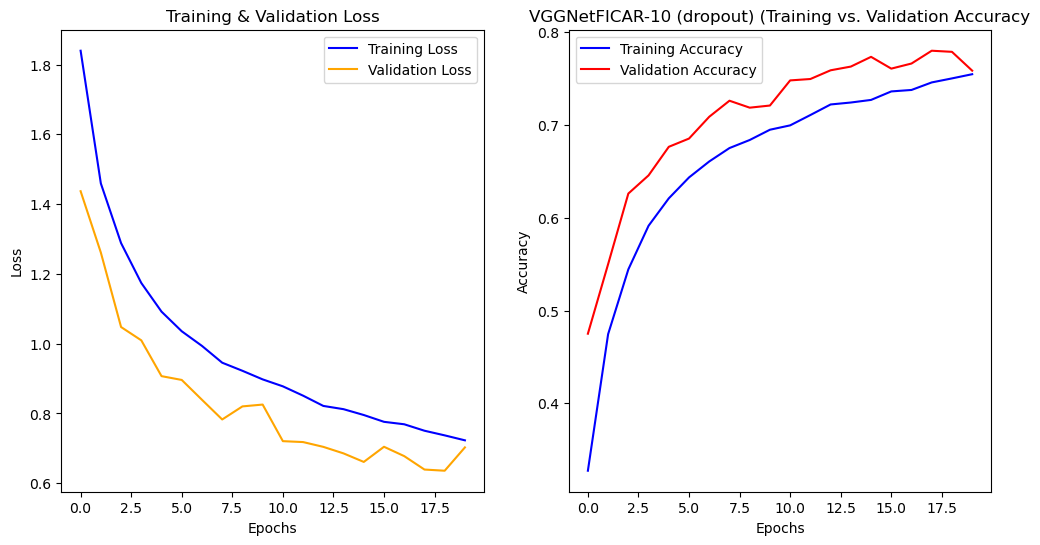


Final Test Accuracy: 0.7587
Precision: 0.7623
Recall: 0.7587
F1 Score: 0.7577


In [ ]:
# Problem 3: Simplified Resnet-18 model CIFAR-10 with Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ResNet Block with Dropout
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, dropout_prob=0.3):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        x = self.dropout2(x)
        return x

# ResNet-18 Model with Dropout
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes, dropout_prob=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)

        self.layer1 = self.__make_layer(64, 64, stride=1, dropout_prob=dropout_prob)
        self.layer2 = self.__make_layer(64, 128, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.__make_layer(128, 256, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.__make_layer(256, 512, stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.fc_dropout = nn.Dropout(p=dropout_prob)

    def __make_layer(self, in_channels, out_channels, stride, dropout_prob):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride, dropout_prob=dropout_prob),
            Block(out_channels, out_channels, dropout_prob=dropout_prob)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_dropout(x)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training & Validation Loss
ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.plot(range(len(val_losses)), val_losses, label="Validation Loss", color="orange")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("VGGNetFICAR-10 (dropout) (Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Train Loss: 3.5815, Val Loss: 3.1866, Val Accuracy: 0.2422
Epoch [2/20], Train Loss: 2.7519, Val Loss: 2.7391, Val Accuracy: 0.3141
Epoch [3/20], Train Loss: 2.3167, Val Loss: 2.5861, Val Accuracy: 0.3810
Epoch [4/20], Train Loss: 1.9981, Val Loss: 2.1906, Val Accuracy: 0.4304
Epoch [5/20], Train Loss: 1.7208, Val Loss: 2.6443, Val Accuracy: 0.4280
Epoch [6/20], Train Loss: 1.4463, Val Loss: 2.1905, Val Accuracy: 0.4609
Epoch [7/20], Train Loss: 1.1642, Val Loss: 2.3196, Val Accuracy: 0.4645
Epoch [8/20], Train Loss: 0.8911, Val Loss: 2.3733, Val Accuracy: 0.4610
Epoch [9/20], Train Loss: 0.6488, Val Loss: 2.5953, Val Accuracy: 0.4592
Epoch [10/20], Train Loss: 0.4624, Val Loss: 3.0505, Val Accuracy: 0.4500
Epoch [11/20], Train Loss: 0.3565, Val Loss: 3.0827, Val Accuracy: 0.4570
Epoch [12/20], Train Loss: 0.2833, Val Loss: 3.1168, Val Accuracy: 0.4583
Epoch [13/20], Train Loss: 0.2599, Val Loss: 3.2850, Val Accuracy: 0.4624
Epoch [14/20], Train Loss: 0.2157, Val Loss: 3.

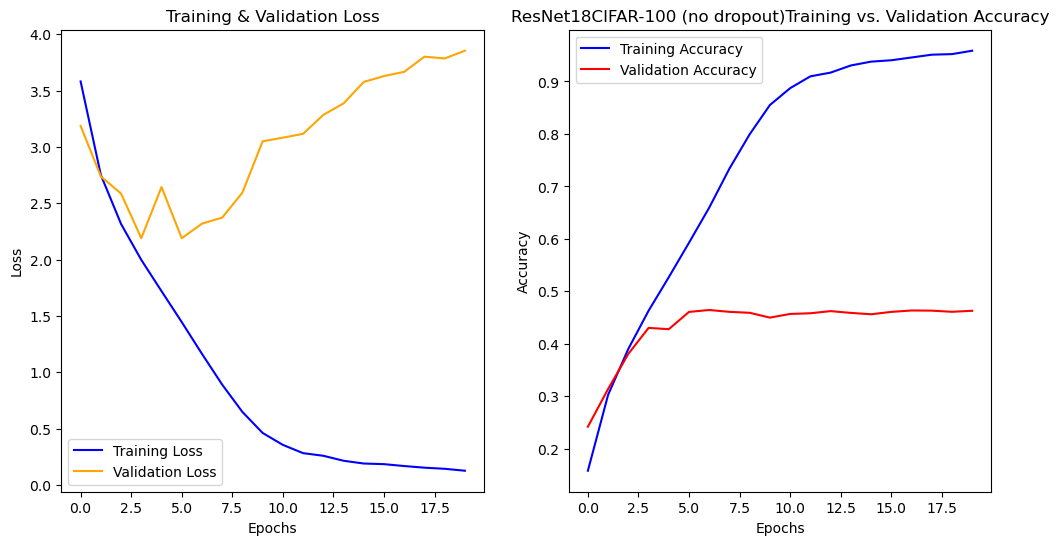


Final Test Accuracy: 0.4630
Precision: 0.4743
Recall: 0.4630
F1 Score: 0.4611


In [ ]:
# Problem 3: Simplified VGGnet model CIFAR-100 without Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Resnet Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

# ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)  # Compute validation loss
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")




# Plot Training & Validation Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training & Validation Loss
ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.plot(range(len(val_losses)), val_losses, label="Validation Loss", color="orange")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()

# Plot Training & Validation Accuracy
ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("ResNet18CIFAR-100 (no dropout)Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Train Loss: 4.4332, Val Loss: 4.0171, Val Accuracy: 0.0629
Epoch [2/20], Train Loss: 3.9212, Val Loss: 3.5595, Val Accuracy: 0.1513
Epoch [3/20], Train Loss: 3.6220, Val Loss: 3.3191, Val Accuracy: 0.1943
Epoch [4/20], Train Loss: 3.4249, Val Loss: 3.1224, Val Accuracy: 0.2256
Epoch [5/20], Train Loss: 3.2629, Val Loss: 2.8996, Val Accuracy: 0.2671
Epoch [6/20], Train Loss: 3.1318, Val Loss: 2.8402, Val Accuracy: 0.2830
Epoch [7/20], Train Loss: 3.0417, Val Loss: 2.6750, Val Accuracy: 0.3138
Epoch [8/20], Train Loss: 2.9564, Val Loss: 2.5878, Val Accuracy: 0.3245
Epoch [9/20], Train Loss: 2.8801, Val Loss: 2.5776, Val Accuracy: 0.3307
Epoch [10/20], Train Loss: 2.8269, Val Loss: 2.5469, Val Accuracy: 0.3365
Epoch [11/20], Train Loss: 2.7733, Val Loss: 2.4299, Val Accuracy: 0.3606
Epoch [12/20], Train Loss: 2.7272, Val Loss: 2.4539, Val Accuracy: 0.3612
Epoch [13/20], Train Loss: 2.6829, Val Loss: 2.3510, Val Accuracy: 0.3818
Epoch [14/20], Train Loss: 2.6434, Val Loss: 2.

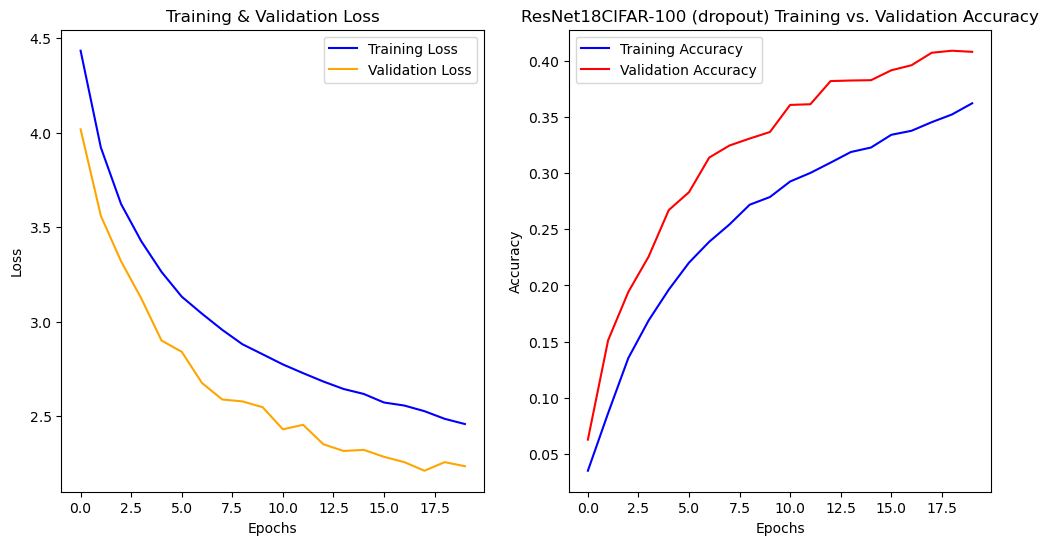


Final Test Accuracy: 0.4078


In [ ]:
# Problem 3: Simplified Resnet-18 model CIFAR-100 with Dropout
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ResNet Block with Dropout
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, dropout_prob=0.3):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        x = self.dropout2(x)
        return x

# ResNet-18 Model with Dropout
class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes, dropout_prob=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)

        self.layer1 = self.__make_layer(64, 64, stride=1, dropout_prob=dropout_prob)
        self.layer2 = self.__make_layer(64, 128, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.__make_layer(128, 256, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.__make_layer(256, 512, stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.fc_dropout = nn.Dropout(p=dropout_prob)

    def __make_layer(self, in_channels, out_channels, stride, dropout_prob):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride, dropout_prob=dropout_prob),
            Block(out_channels, out_channels, dropout_prob=dropout_prob)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_dropout(x)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )


# Initialize model, loss function, and optimizer
model = ResNet18(image_channels=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(test_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time
    return train_losses, val_losses, train_accuracies, val_accuracies, total_time

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.plot(range(len(val_losses)), val_losses, label="Validation Loss", color="orange")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("ResNet18CIFAR-100 (dropout) Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")